### Normalizing Histone Signals

In [1]:
import pandas as pd

# Load the dataset
file_path = "/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv"
df = pd.read_csv(file_path)

# Extract histone marks columns (assuming the column names are known)
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']

# Describe the histone marks to check their distribution
histone_stats = df[histone_marks].describe()

histone_stats

,H3K4me1,H3K4me3,H3K27ac,H3K27me3
count,248957.000000,248957.000000,248957.000000,248957.000000
mean,0.940030,1.691065,1.930584,0.264832
std,3.909459,14.799838,16.352696,0.420024
min,0.000000,0.000000,0.000000,0.000007
25%,0.011573,0.039285,0.012445,0.104090
50%,0.047492,0.091750,0.041324,0.152105
75%,0.195141,0.156673,0.100514,0.274831
max,125.844123,585.777292,581.235974,30.402306


### Run 1: Implementing Attention-Based Neural Network

Loading dataset...
Dataset loaded successfully.
Splitting dataset into train, validation, and test sets...
Dataset split complete.
Applying log transformation and normalization...
Feature transformation complete.
Computing class weights...
Class weights computed.
Building model...
Model built successfully.
Training model...
Epoch 1/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9221 - loss: 0.6651 - val_accuracy: 0.9698 - val_loss: 0.1955
Epoch 2/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9696 - loss: 0.2122 - val_accuracy: 0.9713 - val_loss: 0.1433
Epoch 3/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9692 - loss: 0.1793 - val_accuracy: 0.9686 - val_loss: 0.1593
Epoch 4/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9675 - loss: 0.2021 - val_accuracy: 0.9691 - val_loss: 0.1336
Epoch 5/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9672 - loss: 0.1972 - val_accuracy: 0.9670 - val_loss: 0.1573
Epoch 6/20
5446/5446 ━━

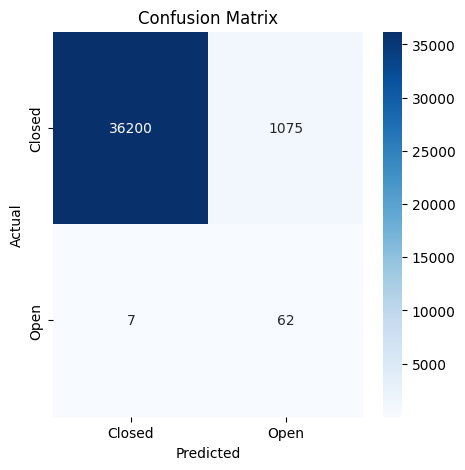

Plotting training history...


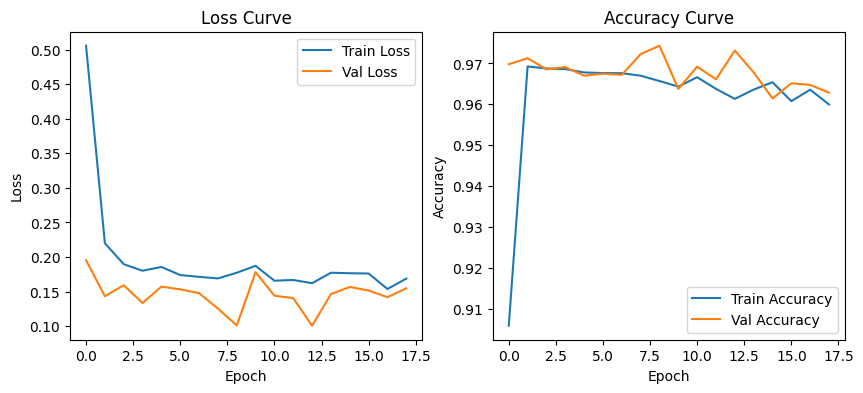

All processes completed successfully.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

metadata = ['Chromosome', 'Start', 'End']
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations]
y = df['chromatin_state']

print("Splitting dataset into train, validation, and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print("Dataset split complete.")

print("Applying log transformation and normalization...")
X_train[histone_marks] = np.log1p(X_train[histone_marks])
X_val[histone_marks] = np.log1p(X_val[histone_marks])
X_test[histone_marks] = np.log1p(X_test[histone_marks])
scaler = StandardScaler()
X_train[histone_marks] = scaler.fit_transform(X_train[histone_marks])
X_val[histone_marks] = scaler.transform(X_val[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])
print("Feature transformation complete.")

print("Computing class weights...")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights computed.")

print("Building model...")
inputs = Input(shape=(X_train.shape[1],))
attention = Dense(X_train.shape[1], activation="softmax")(inputs)
weighted_features = Multiply()([inputs, attention])
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model built successfully.")

print("Training model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                    class_weight=class_weight_dict, callbacks=[early_stopping])
print("Model training complete.")

print("Evaluating model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

print("Generating predictions...")
y_pred_probs = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Classification Threshold: {optimal_threshold:.4f}")

y_pred_opt = (y_pred_probs > optimal_threshold).astype(int)
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)
auc = roc_auc_score(y_test, y_pred_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Plotting training history...")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()
print("All processes completed successfully.")

### Run 2: PR Curve-Based Threshold Optimization

Loading dataset...
Dataset loaded successfully.
Splitting dataset into train, validation, and test sets...
Dataset split complete.
Applying log transformation and normalization...
Feature transformation complete.
Computing class weights...
Class weights computed.
Building model...
Model built successfully.
Training model...
Epoch 1/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9743 - loss: 0.4722 - val_accuracy: 0.9630 - val_loss: 0.1589
Epoch 2/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9584 - loss: 0.2052 - val_accuracy: 0.9743 - val_loss: 0.1303
Epoch 3/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9656 - loss: 0.2119 - val_accuracy: 0.9597 - val_loss: 0.1724
Epoch 4/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9599 - loss: 0.1748 - val_accuracy: 0.9601 - val_loss: 0.1661
Epoch 5/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9604 - loss: 0.1878 - val_accuracy: 0.9522 - val_loss: 0.1980
Epoch 6/20
5446/544

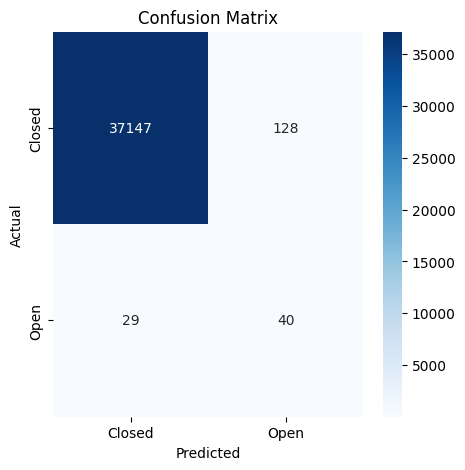

Plotting training history...


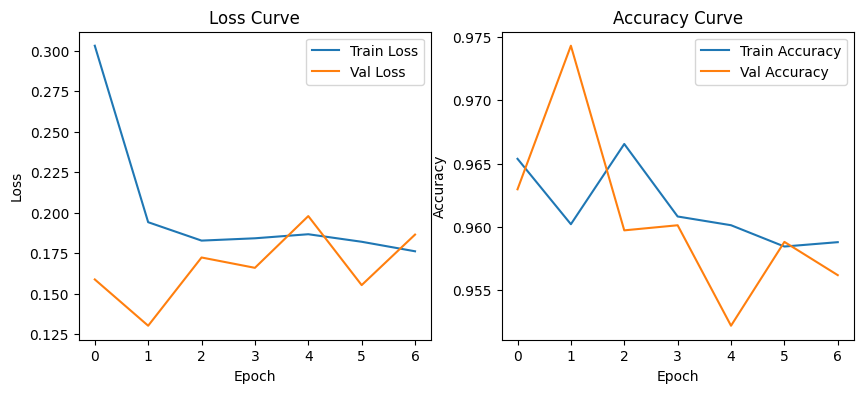

All processes completed successfully.


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

metadata = ['Chromosome', 'Start', 'End']
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations]
y = df['chromatin_state']

print("Splitting dataset into train, validation, and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print("Dataset split complete.")

print("Applying log transformation and normalization...")
X_train[histone_marks] = np.log1p(X_train[histone_marks])
X_val[histone_marks] = np.log1p(X_val[histone_marks])
X_test[histone_marks] = np.log1p(X_test[histone_marks])
scaler = StandardScaler()
X_train[histone_marks] = scaler.fit_transform(X_train[histone_marks])
X_val[histone_marks] = scaler.transform(X_val[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])
print("Feature transformation complete.")

print("Computing class weights...")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights computed.")

print("Building model...")
inputs = Input(shape=(X_train.shape[1],))
attention = Dense(X_train.shape[1], activation="softmax")(inputs)
weighted_features = Multiply()([inputs, attention])
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model built successfully.")

print("Training model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                    class_weight=class_weight_dict, callbacks=[early_stopping])
print("Model training complete.")

print("Evaluating model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

print("Generating predictions...")
y_pred_probs = model.predict(X_test)

# Dynamically adjust threshold to balance precision and recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(precisions * recalls)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
print(f"Optimal Classification Threshold: {optimal_threshold:.4f}")

y_pred_opt = (y_pred_probs > optimal_threshold).astype(int)
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)
auc = roc_auc_score(y_test, y_pred_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Plotting training history...")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()
print("All processes completed successfully.")


### Run 3: Incorporating Focal Loss for Better Handling of Class Imbalance

Loading dataset...
Dataset loaded successfully.
Splitting dataset into train, validation, and test sets...
Dataset split complete.
Applying log transformation and normalization...
Feature transformation complete.
Computing class weights...
Class weights computed: {0: 0.5008219193829282, 1: 304.6660839160839}
Building model...
Model built successfully.
Training model...
Epoch 1/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9904 - loss: 0.0547 - val_accuracy: 0.9869 - val_loss: 0.0037
Epoch 2/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9902 - loss: 0.0052 - val_accuracy: 0.9919 - val_loss: 0.0020
Epoch 3/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9910 - loss: 0.0049 - val_accuracy: 0.9845 - val_loss: 0.0029
Epoch 4/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9883 - loss: 0.0044 - val_accuracy: 0.9832 - val_loss: 0.0027
Epoch 5/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9878 - loss: 0.0041 - val_accuracy:

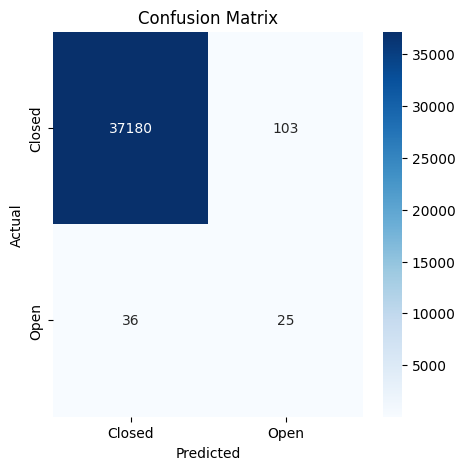

Plotting training history...


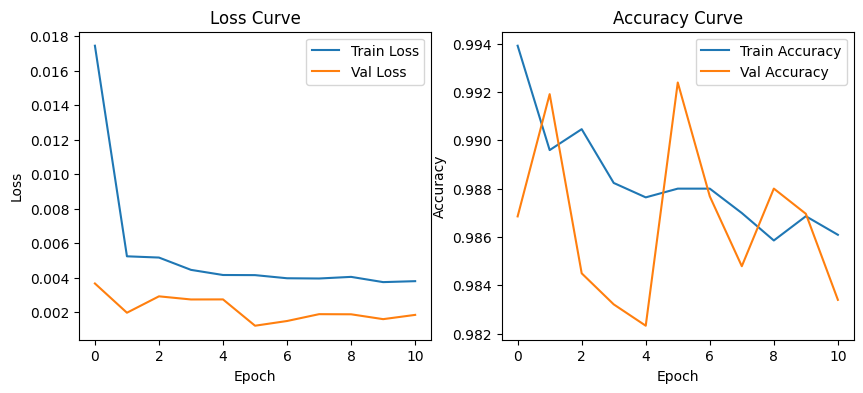

All processes completed successfully.


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define columns
metadata = ['Chromosome', 'Start', 'End']
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations]
y = df['chromatin_state']

# Split the dataset 
print("Splitting dataset into train, validation, and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Dataset split complete.")

# Apply log transformation and normalization
print("Applying log transformation and normalization...")
X_train[histone_marks] = np.log1p(X_train[histone_marks])
X_val[histone_marks] = np.log1p(X_val[histone_marks])
X_test[histone_marks] = np.log1p(X_test[histone_marks])
scaler = StandardScaler()
X_train[histone_marks] = scaler.fit_transform(X_train[histone_marks])
X_val[histone_marks] = scaler.transform(X_val[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])
print("Feature transformation complete.")

# Compute class weights
print("Computing class weights...")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights computed:", class_weight_dict)

# Define Focal Loss to penalise incorrect predictions more
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * (1 - p_t) ** gamma * bce
    return loss

# Build the model
print("Building model...")
inputs = Input(shape=(X_train.shape[1],))
attention = Dense(X_train.shape[1], activation="softmax")(inputs)
weighted_features = Multiply()([inputs, attention])
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])
print("Model built successfully.")

# Train the model
print("Training model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                    class_weight=class_weight_dict, callbacks=[early_stopping])
print("Model training complete.")

# Evaluate the model
print("Evaluating model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
print("Generating predictions...")
y_pred_probs = model.predict(X_test)

# Dynamically find the best threshold using precision-recall tradeoff
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)
best_threshold_idx = np.argmax(precisions * recalls)  # Maximise F1-score tradeoff
best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
print(f"Optimal Classification Threshold: {best_threshold:.4f}")

# Apply optimal threshold
y_pred_opt = (y_pred_probs > best_threshold).astype(int)

# Compute metrics
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)
auc = roc_auc_score(y_test, y_pred_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Confusion Matrix
print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
print("Plotting training history...")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()
print("All processes completed successfully.")

### Run 1 (4): with AUPRC Metric instead of AUROC

Loading dataset...
Dataset loaded successfully.
Splitting dataset into train, validation, and test sets...
Dataset split complete.
Applying log transformation and normalization...
Feature transformation complete.
Computing class weights...
Class weights computed: {0: 0.5008219193829282, 1: 304.6660839160839}
Building model...
Model built successfully.
Training model...
Epoch 1/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9214 - loss: 0.6912 - val_accuracy: 0.9786 - val_loss: 0.1236
Epoch 2/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9661 - loss: 0.2073 - val_accuracy: 0.9713 - val_loss: 0.1366
Epoch 3/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9687 - loss: 0.1690 - val_accuracy: 0.9550 - val_loss: 0.1780
Epoch 4/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9672 - loss: 0.1684 - val_accuracy: 0.9540 - val_loss: 0.1898
Epoch 5/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9619 - loss: 0.1856 - val_accuracy:

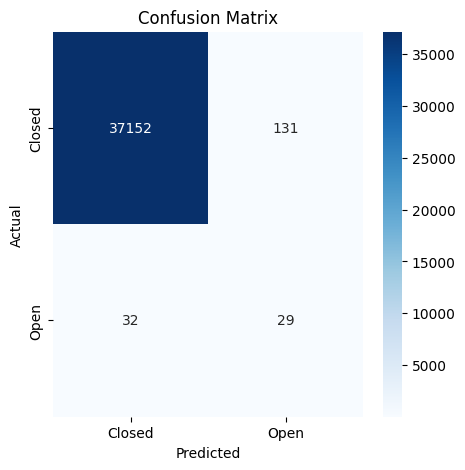

Plotting training history...


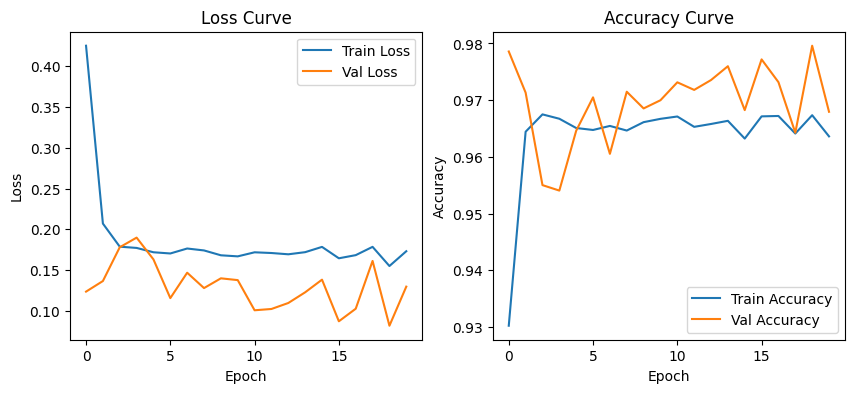

All processes completed successfully.


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define columns
metadata = ['Chromosome', 'Start', 'End']
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations]
y = df['chromatin_state']

# Split dataset
print("Splitting dataset into train, validation, and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Dataset split complete.")

# Apply log transformation and normalization
print("Applying log transformation and normalization...")
X_train[histone_marks] = np.log1p(X_train[histone_marks])
X_val[histone_marks] = np.log1p(X_val[histone_marks])
X_test[histone_marks] = np.log1p(X_test[histone_marks])
scaler = StandardScaler()
X_train[histone_marks] = scaler.fit_transform(X_train[histone_marks])
X_val[histone_marks] = scaler.transform(X_val[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])
print("Feature transformation complete.")

# Compute class weights
print("Computing class weights...")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights computed:", class_weight_dict)

# Build model
print("Building model...")
inputs = Input(shape=(X_train.shape[1],))
attention = Dense(X_train.shape[1], activation="softmax")(inputs)
weighted_features = Multiply()([inputs, attention])
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model built successfully.")

# Train the model
print("Training model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                    class_weight=class_weight_dict, callbacks=[early_stopping])
print("Model training complete.")

# Evaluate the model
print("Evaluating model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
print("Generating predictions...")
y_pred_probs = model.predict(X_test)

# Compute Precision-Recall AUC (AUPRC)
auprc = average_precision_score(y_test, y_pred_probs)
print(f"AUPRC (Precision-Recall AUC): {auprc:.4f}")

# Find optimal classification threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)
best_threshold_idx = np.argmax(precisions * recalls)  # Maximizing F1-score tradeoff
best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
print(f"Optimal Classification Threshold: {best_threshold:.4f}")

# Apply optimal threshold
y_pred_opt = (y_pred_probs > best_threshold).astype(int)

# Compute metrics
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
print("Plotting training history...")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()
print("All processes completed successfully.")


### Run 5: Applying SMOTE and Tomek Links 

In [3]:
!pip install imbalanced-learn
!pip install scikeras

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)


Dataset loaded successfully.
Dataset split complete.
Applying SMOTE + Tomek...
New class distribution after SMOTE + Tomek: [173963 173963]
Applying log transformation and normalization...
Feature transformation complete.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9579 - loss: 0.2339 - val_accuracy: 0.9679 - val_loss: 0.1247
Epoch 2/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9693 - loss: 0.1282 - val_accuracy: 0.9697 - val_loss: 0.1169
Epoch 3/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9700 - loss: 0.1209 - val_accuracy: 0.9716 - val_loss: 0.1110
Epoch 4/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9708 - loss: 0.1158 - val_accuracy: 0.9708 - val_loss: 0.1068
Epoch 5/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9707 - loss: 0.1133 - val_accuracy: 0.9707 - val_loss: 0.1048
Epoch 6/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9714 - loss: 0.1105 - val_accuracy: 0.9726 - val_loss: 0.1036
Epoch 7/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9712 - loss: 0.1097 - val_accuracy: 0.9686 - val_loss: 0.1074
Epoch 8/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9711 - loss: 0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7249/7249 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9550 - loss: 0.2383 - val_accuracy: 0.9666 - val_loss: 0.1272
Epoch 2/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9677 - loss: 0.1304 - val_accuracy: 0.9698 - val_loss: 0.1151
Epoch 3/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9706 - loss: 0.1186 - val_accuracy: 0.9723 - val_loss: 0.1090
Epoch 4/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9707 - loss: 0.1154 - val_accuracy: 0.9727 - val_loss: 0.1072
Epoch 5/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9718 - loss: 0.1096 - val_accuracy: 0.9731 - val_loss: 0.1052
Epoch 6/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9708 - loss: 0.1096 - val_accuracy: 0.9710 - val_loss: 0.1041
Epoch 7/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9712 - loss: 0.1080 - val_accuracy: 0.9726 - val_loss: 0.1021
Epoch 8/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9714 - loss: 0.1069 - val

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



7249/7249 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9548 - loss: 0.2378 - val_accuracy: 0.9707 - val_loss: 0.1215
Epoch 2/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9679 - loss: 0.1305 - val_accuracy: 0.9701 - val_loss: 0.1191
Epoch 3/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9689 - loss: 0.1225 - val_accuracy: 0.9732 - val_loss: 0.1103
Epoch 4/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9700 - loss: 0.1166 - val_accuracy: 0.9741 - val_loss: 0.1023
Epoch 5/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9695 - loss: 0.1141 - val_accuracy: 0.9685 - val_loss: 0.1080
Epoch 6/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9707 - loss: 0.1099 - val_accuracy: 0.9711 - val_loss: 0.0997
Epoch 7/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9705 - loss: 0.1088 - val_accuracy: 0.9738 - val_loss: 0.0985
Epoch 8/20
7249/7249 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9706 - loss: 0.1074 - val

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



10873/10873 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9584 - loss: 0.2089 - val_accuracy: 0.9712 - val_loss: 0.1174
Epoch 2/20
10873/10873 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9695 - loss: 0.1234 - val_accuracy: 0.9738 - val_loss: 0.0993
Epoch 3/20
10873/10873 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9709 - loss: 0.1145 - val_accuracy: 0.9611 - val_loss: 0.1215
Epoch 4/20
10873/10873 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9711 - loss: 0.1106 - val_accuracy: 0.9664 - val_loss: 0.1129
Epoch 5/20
10873/10873 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9709 - loss: 0.1101 - val_accuracy: 0.9699 - val_loss: 0.1070
Epoch 6/20
10873/10873 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9714 - loss: 0.1065 - val_accuracy: 0.9632 - val_loss: 0.1196
Epoch 7/20
10873/10873 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9715 - loss: 0.1058 - val_accuracy: 0.9664 - val_loss: 0.1183
Evaluating final model...
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy:

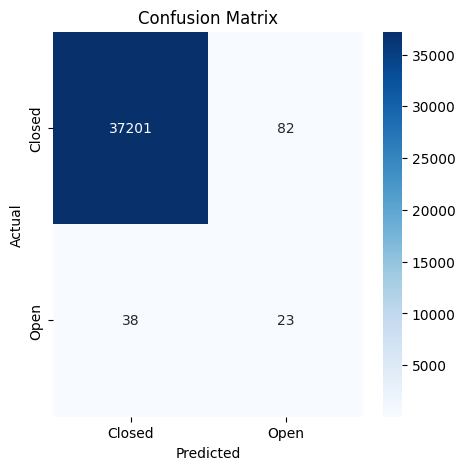

All processes completed successfully.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTETomek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define feature columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations]
y = df['chromatin_state']

# Split dataset before applying SMOTE + Tomek
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Dataset split complete.")

# Apply SMOTE + Tomek on training data only
print("Applying SMOTE + Tomek...")
smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)
print(f"New class distribution after SMOTE + Tomek: {np.bincount(y_train_resampled)}")

# Apply log transformation and normalization
print("Applying log transformation and normalization...")
X_train_resampled[histone_marks] = np.log1p(X_train_resampled[histone_marks])
X_val[histone_marks] = np.log1p(X_val[histone_marks])
X_test[histone_marks] = np.log1p(X_test[histone_marks])
scaler = StandardScaler()
X_train_resampled[histone_marks] = scaler.fit_transform(X_train_resampled[histone_marks])
X_val[histone_marks] = scaler.transform(X_val[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])
print("Feature transformation complete.")

# Define model function for KerasClassifier
def build_model(neurons=64, learning_rate=0.001, dropout_rate=0.3):
    model = tf.keras.Sequential([
        Dense(neurons, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_resampled.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons // 2, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_results = []

for train_idx, val_idx in skf.split(X_train_resampled, y_train_resampled):
    X_train_fold, X_val_fold = X_train_resampled.iloc[train_idx], X_train_resampled.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_idx], y_train_resampled.iloc[val_idx]
    
    model = build_model(neurons=64, learning_rate=0.001, dropout_rate=0.3)
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=20, batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold)
    cv_results.append(val_acc)

print("Cross-validation results:", cv_results)
print("Mean accuracy across folds:", np.mean(cv_results))

# Train final model
print("Training final model on full dataset...")
best_model = build_model()
best_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=20, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model
print("Evaluating final model...")
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred_probs = best_model.predict(X_test)
auprc = average_precision_score(y_test, y_pred_probs)
print(f"AUPRC (Precision-Recall AUC): {auprc:.4f}")

# Find optimal classification threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)
best_threshold_idx = np.argmax(precisions * recalls)
best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
print(f"Optimal Classification Threshold: {best_threshold:.4f}")

# Apply optimal threshold
y_pred_opt = (y_pred_probs > best_threshold).astype(int)

# Compute metrics
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("All processes completed successfully.")

### Run 6: Optimize Threshold Selection (Move Beyond ROC & AUPRC)

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define feature and target columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
target_column = 'chromatin_state'

# Extract features (X) and target (y)
X = df[histone_marks + annotations].copy()
y = df[target_column].values

# Apply log transformation and normalization to histone marks
X[histone_marks] = np.log1p(X[histone_marks])  # log(1+x) to handle small values
scaler = StandardScaler()
X[histone_marks] = scaler.fit_transform(X[histone_marks])

# Convert to NumPy arrays for TensorFlow compatibility
X = X.to_numpy()

# Split dataset into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Define function to create model
def create_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Stratified K-Fold cross-validation with threshold optimization
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_thresholds = []
fold_metrics = []  # to store (precision, recall, F1) for each fold

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    print(f"\nTraining Fold {fold}...")
    
    # Split train and validation sets
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Train model on this fold
    model = create_model(input_dim=X.shape[1])
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)  # Adjust epochs if needed

    # Get predicted probabilities for validation set
    y_val_proba = model.predict(X_val_fold).ravel()

    # Find best threshold using precision-recall curve
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_val_fold, y_val_proba)
    f1_vals = (2 * precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    f1_vals = f1_vals[:-1]  # Drop last value (no corresponding threshold)
    best_idx = np.argmax(f1_vals)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_vals[best_idx]
    best_prec = precision_vals[best_idx]
    best_rec = recall_vals[best_idx]

    # Store results
    best_thresholds.append(best_thresh)
    fold_metrics.append((best_prec, best_rec, best_f1))
    print(f"Fold {fold}: Best Threshold = {best_thresh:.3f}, Precision = {best_prec:.3f}, Recall = {best_rec:.3f}, F1 = {best_f1:.3f}")

# Compute average optimal threshold and performance across folds
avg_best_thresh = np.mean(best_thresholds)
avg_prec = np.mean([m[0] for m in fold_metrics])
avg_rec = np.mean([m[1] for m in fold_metrics])
avg_f1 = np.mean([m[2] for m in fold_metrics])
print(f"\nAverage optimal threshold across folds: {avg_best_thresh:.3f}")
print(f"Average Precision = {avg_prec:.3f}, Average Recall = {avg_rec:.3f}, Average F1 = {avg_f1:.3f}")

# Train final model on full training set
print("\nTraining final model on full dataset...")
final_model = create_model(input_dim=X.shape[1])
final_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate final model on test set
y_test_proba = final_model.predict(X_test).ravel()
y_test_pred = (y_test_proba >= avg_best_thresh).astype(int)
test_prec = precision_score(y_test, y_test_pred, zero_division=0)
test_rec = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

# Print final test results
print(f"\nFinal Model Evaluation at Threshold = {avg_best_thresh:.3f}:")
print(f"Test Precision = {test_prec:.3f}, Test Recall = {test_rec:.3f}, Test F1 = {test_f1:.3f}")


Training Fold 1...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step
Fold 1: Best Threshold = 0.216, Precision = 0.333, Recall = 0.368, F1 = 0.350

Training Fold 2...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step
Fold 2: Best Threshold = 0.173, Precision = 0.312, Recall = 0.526, F1 = 0.392

Training Fold 3...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step
Fold 3: Best Threshold = 0.222, Precision = 0.325, Recall = 0.456, F1 = 0.380

Training Fold 4...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step
Fold 4: Best Threshold = 0.232, Precision = 0.247, Recall = 0.397, F1 = 0.305

Training Fold 5...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step
Fold 5: Best Threshold = 0.186, Precision = 0.264, Recall = 0.596, F1 = 0.366

Average optimal threshold across folds: 0.206
Average Precision = 0.296, Average Recall = 0.469, Average F1 = 0.358

Training final model on full dataset...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2334/2334 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step

Final Model Evaluation at Threshold = 0.206:
Test Precision = 0.234, Test Recall = 0.504, Test F1 = 0.320


### Visualization of Precision-Recall vs. Threshold

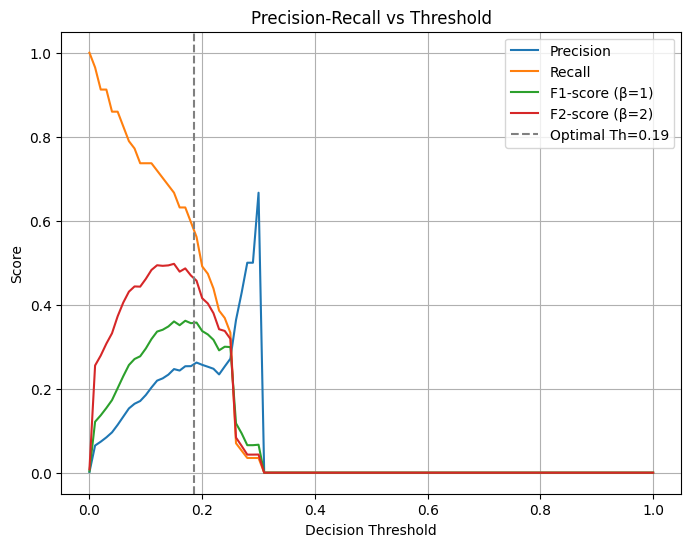

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

# Use last fold's validation predictions and labels for visualization
y_score = y_val_proba  # last fold's predicted probabilities
y_true = y_val_fold  # last fold's ground truth labels

thresholds = np.linspace(0, 1, 101)  # Threshold range from 0 to 1
precisions, recalls, f1_scores, f2_scores = [], [], [], []

for t in thresholds:
    y_pred = (y_score >= t).astype(int)  # Convert probabilities to binary labels
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(recall_score(y_true, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_true, y_pred, zero_division=0))
    f2_scores.append(fbeta_score(y_true, y_pred, beta=2, zero_division=0))

# Plot precision, recall, F1, and F2 against the threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score (β=1)')
plt.plot(thresholds, f2_scores, label='F2-score (β=2)')
plt.axvline(x=best_thresh, color='gray', linestyle='--', label=f'Optimal Th={best_thresh:.2f}')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Run 7: Feature Engineering: Introduce Interaction Terms with Bias

In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Define feature and target columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
target_column = 'chromatin_state'

# Extract features (X) and target (y)
X = df[histone_marks + annotations].copy()
y = df[target_column].values

# Apply log transformation to histone marks (no data leakage)
X[histone_marks] = np.log1p(X[histone_marks])

# Split dataset first to avoid leakage in transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Prevent Data Leakage
# Step 1: Fit PolynomialFeatures only on training data
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)  # Only transform, do not fit

# Step 2: Fit StandardScaler only on training data
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)  # Only transform, do not fit

# Update X_train and X_test
X_train, X_test = X_train_poly, X_test_poly

# Define model using Input(shape=...) instead of input_dim
def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),  # Correct way to define input shape
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Stratified K-Fold cross-validation with threshold optimization
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_thresholds = []
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    print(f"\nTraining Fold {fold}...")

    # Split train and validation sets
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Train model on this fold
    model = create_model(input_dim=X_train.shape[1])
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Get predicted probabilities for validation set
    y_val_proba = model.predict(X_val_fold).ravel()

    # Find best threshold using precision-recall curve
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_val_fold, y_val_proba)
    f1_vals = (2 * precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    f1_vals = f1_vals[:-1]
    best_idx = np.argmax(f1_vals)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_vals[best_idx]
    best_prec = precision_vals[best_idx]
    best_rec = recall_vals[best_idx]

    # Store results
    best_thresholds.append(best_thresh)
    fold_metrics.append((best_prec, best_rec, best_f1))
    print(f"Fold {fold}: Best Threshold = {best_thresh:.3f}, Precision = {best_prec:.3f}, Recall = {best_rec:.3f}, F1 = {best_f1:.3f}")

# Compute average optimal threshold and performance across folds
avg_best_thresh = np.mean(best_thresholds)
avg_prec = np.mean([m[0] for m in fold_metrics])
avg_rec = np.mean([m[1] for m in fold_metrics])
avg_f1 = np.mean([m[2] for m in fold_metrics])
print(f"\nAverage optimal threshold across folds: {avg_best_thresh:.3f}")
print(f"Average Precision = {avg_prec:.3f}, Average Recall = {avg_rec:.3f}, Average F1 = {avg_f1:.3f}")

# Train final model on full training set
print("\nTraining final model on full dataset...")
final_model = create_model(input_dim=X_train.shape[1])
final_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Evaluate final model on test set
y_test_proba = final_model.predict(X_test).ravel()
y_test_pred = (y_test_proba >= avg_best_thresh).astype(int)
test_prec = precision_score(y_test, y_test_pred, zero_division=0)
test_rec = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

# Print final test results
print(f"\nFinal Model Evaluation at Threshold = {avg_best_thresh:.3f}:")
print(f"Test Precision = {test_prec:.3f}, Test Recall = {test_rec:.3f}, Test F1 = {test_f1:.3f}")


Training Fold 1...
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step
Fold 1: Best Threshold = 0.211, Precision = 0.357, Recall = 0.351, F1 = 0.354

Training Fold 2...
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step
Fold 2: Best Threshold = 0.200, Precision = 0.333, Recall = 0.491, F1 = 0.397

Training Fold 3...
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step
Fold 3: Best Threshold = 0.077, Precision = 0.167, Recall = 0.614, F1 = 0.263

Training Fold 4...
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step
Fold 4: Best Threshold = 0.234, Precision = 0.230, Recall = 0.500, F1 = 0.315

Training Fold 5...
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step
Fold 5: Best Threshold = 0.201, Precision = 0.305, Recall = 0.509, F1 = 0.382

Average optimal threshold across folds: 0.185
Average Precision = 0.279, Average Recall = 0.493, Average F1 = 0.342

Training final model on full dataset...
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 2s 680us/step

Final Model Evaluation at Threshold = 0.185:
Test Precision = 0.223, Test Recall 

### Run 8: Focal Loss Optimization

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define feature columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations]
y = df['chromatin_state']

# Check for negative values & fix before log transformation
print("Checking for negative values in histone marks...")
if (X[histone_marks] < 0).any().any():
    print("Negative values detected, shifting data...")
    shift_value = -X[histone_marks].min().min() + 1e-5
    X[histone_marks] += shift_value

# Apply log transformation and normalization
print("Applying log transformation and normalization...")
X.loc[:, histone_marks] = np.log1p(X[histone_marks])
scaler = StandardScaler()
X.loc[:, histone_marks] = scaler.fit_transform(X[histone_marks])
print("Feature transformation complete.")

# Compute class weights
print("Computing class weights...")
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights computed:", class_weight_dict)

# Define Focal Loss function
def focal_loss(alpha, gamma):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * (1 - p_t) ** gamma * bce
    return loss

# Define Neural Network Model
def build_model(alpha, gamma):
    inputs = Input(shape=(X.shape[1],))
    attention = Dense(X.shape[1], activation="softmax")(inputs)
    weighted_features = Multiply()([inputs, attention])
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss=focal_loss(alpha, gamma), metrics=['accuracy'])
    return model

# Hyperparameter grid for focal loss
alpha_values = [0.1, 0.25, 0.5]
gamma_values = [1.0, 2.0, 3.0]

best_f1 = 0
best_alpha = 0
best_gamma = 0

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("Running Stratified K-Fold to optimize Focal Loss parameters...")
for alpha in alpha_values:
    for gamma in gamma_values:
        precision_scores = []
        recall_scores = []
        f1_scores = []
        auprc_scores = []

        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = build_model(alpha, gamma)
            history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                                validation_data=(X_val, y_val),
                                callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                                class_weight=class_weight_dict, verbose=0)

            # Generate predictions
            y_val_pred_probs = model.predict(X_val)
            precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_probs)
            best_threshold_idx = np.argmax(precisions * recalls)
            best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
            y_val_pred = (y_val_pred_probs > best_threshold).astype(int)

            # Compute metrics
            precision = precision_score(y_val, y_val_pred)
            recall = recall_score(y_val, y_val_pred)
            f1 = f1_score(y_val, y_val_pred)
            auprc = average_precision_score(y_val, y_val_pred_probs)

            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            auprc_scores.append(auprc)

        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1 = np.mean(f1_scores)
        mean_auprc = np.mean(auprc_scores)

        print(f"Alpha={alpha}, Gamma={gamma} -> Mean Precision: {mean_precision:.4f}, Mean Recall: {mean_recall:.4f}, Mean F1: {mean_f1:.4f}, Mean AUPRC: {mean_auprc:.4f}")

        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_alpha = alpha
            best_gamma = gamma

print(f"Best Focal Loss Params -> Alpha: {best_alpha}, Gamma: {best_gamma}, Best Precision: {mean_precision:.4f}, Best Recall: {mean_recall:.4f}, Best F1 Score: {best_f1:.4f}")

# Train final model with best hyperparameters
print("Training final model with best Focal Loss parameters...")
final_model = build_model(best_alpha, best_gamma)
final_model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2,
                callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                class_weight=class_weight_dict)

print("Final Model Training Complete.")

Loading dataset...
Dataset loaded successfully.
Checking for negative values in histone marks...
Applying log transformation and normalization...
Feature transformation complete.
Computing class weights...
Class weights computed: {0: 0.500822778698682, 1: 304.3484107579462}
Running Stratified K-Fold to optimize Focal Loss parameters...
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 690us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 727us/step
Alpha=0.1, Gamma=1.0 -> Mean Precision: 0.1746, Mean Recall: 0.4888, Mean F1: 0.2563, Mean AUPRC: 0.1513
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 741us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 774us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 743us/step
Alpha=0.1, Gamma=2.0 -> Mean Precision: 0.1506, Mean Recall: 0.6334, Mean F1: 0.2283, Mean AUPRC: 0.1430
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 735us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 668us/step


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 661us/step
Alpha=0.1, Gamma=3.0 -> Mean Precision: 0.0064, Mean Recall: 0.3456, Mean F1: 0.0126, Mean AUPRC: 0.0072
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 660us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 675us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 680us/step
Alpha=0.25, Gamma=1.0 -> Mean Precision: 0.1222, Mean Recall: 0.6604, Mean F1: 0.1923, Mean AUPRC: 0.1267
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 659us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 679us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 730us/step
Alpha=0.25, Gamma=2.0 -> Mean Precision: 0.1847, Mean Recall: 0.5599, Mean F1: 0.2755, Mean AUPRC: 0.1792
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 697us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 734us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 757us/step
Alpha=0.25, Gamma=3.0 -> Mean Precision: 0.1133, Mean Recall: 0.7064, Mean F1: 0.1428, Mean AUPRC: 0.0654
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 744us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 683us/step
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 2s 696

### Run 9: Class Weight Optimization
1. Balanced - Standard method from compute_class_weight('balanced', ...)
2. Manually Adjusted - Increase the weight of minority class (e.g., weight ratio: 10:1, 50:1, 100:1)
3. Inverse Frequency - Compute class weights based on inverse class frequencies

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define feature columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
target_column = 'chromatin_state'

# Extract features (X) and target (y)
X = df[histone_marks + annotations].copy()
y = df[target_column].values  # Convert y to NumPy array

# **Preserve negative correlations in histone marks (No log transformation)**

# Split dataset before transformations to prevent data leakage
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply standardization separately on training data
scaler = StandardScaler()
X_train_val.loc[:, histone_marks] = scaler.fit_transform(X_train_val[histone_marks])
X_test.loc[:, histone_marks] = scaler.transform(X_test[histone_marks])  # Apply the same scaling

print("Feature transformation complete.")

# **Class Weights Optimization**
print("Computing class weights...")
total_samples = len(y_train_val)
class_counts = np.bincount(y_train_val)

class_weights = {
    'balanced': {i: weight for i, weight in enumerate(compute_class_weight('balanced', classes=np.unique(y_train_val), y=y_train_val))},
    'manual_10': {0: 1, 1: 10},  
    'manual_50': {0: 1, 1: 50},  
    'manual_100': {0: 1, 1: 100},  
    'inverse_freq': {0: total_samples / class_counts[0], 1: total_samples / class_counts[1]}  
}

# **Define Neural Network Model**
def build_model(input_dim):
    inputs = Input(shape=(input_dim,))
    attention = Dense(input_dim, activation="softmax")(inputs)
    weighted_features = Multiply()([inputs, attention])
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **Stratified K-Fold to Find Best Class Weights**
best_f1 = 0
best_precision = 0
best_recall = 0
best_strategy = ""
best_class_weight = {}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("Running Stratified K-Fold to optimize Class Weights...")
for strategy, weights in class_weights.items():
    f1_scores = []
    precision_scores = []
    recall_scores = []
    auprc_scores = []

    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Re-apply standardization (no leakage)
        X_train.loc[:, histone_marks] = scaler.fit_transform(X_train[histone_marks])
        X_val.loc[:, histone_marks] = scaler.transform(X_val[histone_marks])

        model = build_model(input_dim=X_train.shape[1])
        history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                            class_weight=weights, verbose=0)

        # Get predicted probabilities and compute the best threshold
        y_val_pred_probs = model.predict(X_val)
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_probs)
        best_threshold_idx = np.argmax(precisions * recalls)
        best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
        y_val_pred = (y_val_pred_probs > best_threshold).astype(int)

        # Compute metrics
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)
        auprc = average_precision_score(y_val, y_val_pred_probs)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        auprc_scores.append(auprc)

    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_auprc = np.mean(auprc_scores)

    print(f"Strategy: {strategy} -> Mean Precision: {mean_precision:.4f}, Mean Recall: {mean_recall:.4f}, Mean F1: {mean_f1:.4f}, Mean AUPRC: {mean_auprc:.4f}")

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_precision = mean_precision
        best_recall = mean_recall
        best_strategy = strategy
        best_class_weight = weights

print(f"Best Class Weight Strategy -> {best_strategy} with Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, F1 Score: {best_f1:.4f}")

# **Train Final Model Using Best Class Weights**
print("Training final model with best Class Weight Strategy...")
final_model = build_model(input_dim=X_train_val.shape[1])
final_model.fit(X_train_val, y_train_val, epochs=20, batch_size=32, validation_split=0.2,
                callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                class_weight=best_class_weight, verbose=0)

# **Evaluate on Test Set**
print("Evaluating on test set...")
y_test_pred_probs = final_model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred_probs)
best_threshold_idx = np.argmax(precisions * recalls)
best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
y_test_pred = (y_test_pred_probs > best_threshold).astype(int)

# Compute final test metrics
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auprc = average_precision_score(y_test, y_test_pred_probs)

print(f"Test Set Evaluation -> Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, AUPRC: {test_auprc:.4f}")
print("Final Model Training & Evaluation Complete.")

Loading dataset...
Dataset loaded successfully.
Feature transformation complete.
Computing class weights...
Running Stratified K-Fold to optimize Class Weights...
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 747us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step
Strategy: balanced -> Mean Precision: 0.1882, Mean Recall: 0.5627, Mean F1: 0.2791, Mean AUPRC: 0.1872
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 701us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 724us/step
Strategy: manual_10 -> Mean Precision: 0.1907, Mean Recall: 0.4740, Mean F1: 0.2634, Mean AUPRC: 0.1532
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 711us/step
Strategy: manual_50 -> Mean Precision: 0.1892, Mean Recall: 0.5780, Mean F1: 0.2791, Mean AUPRC: 0.1837
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 712us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 700us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 

### Run 10: Oversampling with SMOTE and Duplication

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define feature columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations].copy()
y = df['chromatin_state'].copy()

# Split dataset (test set untouched)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
print("Applying normalization...")
scaler = StandardScaler()
X_train_val.loc[:, histone_marks] = scaler.fit_transform(X_train_val[histone_marks])
X_test.loc[:, histone_marks] = scaler.transform(X_test[histone_marks])  # Apply same transformation
print("Feature transformation complete.")

# **SMOTE Oversampling**
print("Applying SMOTE oversampling on training set...")
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_val_smote, y_train_val_smote = smote.fit_resample(X_train_val, y_train_val)
print(f"New Class Distribution (After SMOTE): {np.bincount(y_train_val_smote)}")  # Expected: [198838, 198838]

# **Duplicate Oversampling**
def duplicate_oversample(X, y, target_count):
    """Duplicate minority class instances until they match the majority count."""
    minority_idx = y[y == 1].index
    majority_idx = y[y == 0].index
    
    # Get original counts
    minority_X = X.loc[minority_idx].copy()
    minority_y = y.loc[minority_idx].copy()
    
    # Calculate duplications needed
    required_duplications = target_count - len(minority_y)
    
    if required_duplications > 0:
        duplicates_X = minority_X.sample(n=required_duplications, replace=True, random_state=42)
        duplicates_y = minority_y.sample(n=required_duplications, replace=True, random_state=42)
        
        # Add new duplicated samples
        X = pd.concat([X, duplicates_X], axis=0)
        y = pd.concat([y, duplicates_y], axis=0)
    
    return X.sample(frac=1, random_state=42), y.sample(frac=1, random_state=42)  # Shuffle

print("Applying duplicate oversampling on training set...")
X_train_val_dup, y_train_val_dup = duplicate_oversample(X_train_val, y_train_val, target_count=198838)
print(f"New Class Distribution (After Duplicate Oversampling): {np.bincount(y_train_val_dup)}")  # Expected: [198838, 198838]

# Define Neural Network Model
def build_model(input_dim):
    inputs = Input(shape=(input_dim,))
    attention = Dense(input_dim, activation="softmax")(inputs)
    weighted_features = Multiply()([inputs, attention])
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **Stratified K-Fold for Training & Threshold Optimization**
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for K-Fold validation
kfold_results_smote = []
kfold_results_dup = []

print("Running Stratified K-Fold to optimize Decision Threshold (SMOTE & Duplicate Oversampling)...")

# **Run K-Fold for SMOTE**
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val_smote, y_train_val_smote), start=1):
    X_train, X_val = X_train_val_smote.iloc[train_idx], X_train_val_smote.iloc[val_idx]
    y_train, y_val = y_train_val_smote.iloc[train_idx], y_train_val_smote.iloc[val_idx]

    model = build_model(input_dim=X_train.shape[1])
    model.fit(X_train, y_train, epochs=10, batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
              verbose=0)

    # Compute optimal threshold
    y_val_pred_probs = model.predict(X_val)
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_probs)
    best_threshold_idx = np.argmax(precisions * recalls)
    best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

    precision = precision_score(y_val, (y_val_pred_probs > best_threshold).astype(int))
    recall = recall_score(y_val, (y_val_pred_probs > best_threshold).astype(int))
    f1 = f1_score(y_val, (y_val_pred_probs > best_threshold).astype(int))
    auprc = average_precision_score(y_val, y_val_pred_probs)

    kfold_results_smote.append((fold, precision, recall, f1, auprc, best_threshold))
    print(f"SMOTE Fold {fold} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}")

# **Run K-Fold for Duplicate Oversampling**
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val_dup, y_train_val_dup), start=1):
    X_train, X_val = X_train_val_dup.iloc[train_idx], X_train_val_dup.iloc[val_idx]
    y_train, y_val = y_train_val_dup.iloc[train_idx], y_train_val_dup.iloc[val_idx]

    model = build_model(input_dim=X_train.shape[1])
    model.fit(X_train, y_train, epochs=10, batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
              verbose=0)

    # Compute optimal threshold
    y_val_pred_probs = model.predict(X_val)
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_probs)
    best_threshold_idx = np.argmax(precisions * recalls)
    best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

    precision = precision_score(y_val, (y_val_pred_probs > best_threshold).astype(int))
    recall = recall_score(y_val, (y_val_pred_probs > best_threshold).astype(int))
    f1 = f1_score(y_val, (y_val_pred_probs > best_threshold).astype(int))
    auprc = average_precision_score(y_val, y_val_pred_probs)

    kfold_results_dup.append((fold, precision, recall, f1, auprc, best_threshold))
    print(f"Duplicate Oversampling Fold {fold} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}")

# **Print final K-Fold results**
print("\nFinal K-Fold Results for SMOTE:")
print(pd.DataFrame(kfold_results_smote, columns=["Fold", "Precision", "Recall", "F1", "AUPRC", "Threshold"]))

print("\nFinal K-Fold Results for Duplicate Oversampling:")
print(pd.DataFrame(kfold_results_dup, columns=["Fold", "Precision", "Recall", "F1", "AUPRC", "Threshold"]))

Loading dataset...
Dataset loaded successfully.
Applying normalization...
Feature transformation complete.
Applying SMOTE oversampling on training set...
New Class Distribution (After SMOTE): [198838 198838]
Applying duplicate oversampling on training set...
New Class Distribution (After Duplicate Oversampling): [198838 198838]
Running Stratified K-Fold to optimize Decision Threshold (SMOTE & Duplicate Oversampling)...
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 2s 846us/step
SMOTE Fold 1 - Precision: 0.9680, Recall: 0.9668, F1: 0.9674, AUPRC: 0.9911
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step
SMOTE Fold 2 - Precision: 0.9687, Recall: 0.9715, F1: 0.9701, AUPRC: 0.9893
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 2s 666us/step
SMOTE Fold 3 - Precision: 0.9701, Recall: 0.9661, F1: 0.9681, AUPRC: 0.9909
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 2s 724us/step
SMOTE Fold 4 - Precision: 0.9690, Recall: 0.9689, F1: 0.9690, AUPRC: 0.9921
2486/2486 ━━━━━━━━━━━━━━━━━━━━ 2s 661us/step
SMOTE Fold 5 - Precision: 0.9719, Recall: 0.9695


Evaluating Final SMOTE Model on Test Set...
1556/1556 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Final Test Set Evaluation (SMOTE Model):
Precision: 0.0409
Recall: 0.9390
F1 Score: 0.0784
AUPRC: 0.1870
Optimized Threshold Used: 0.4684


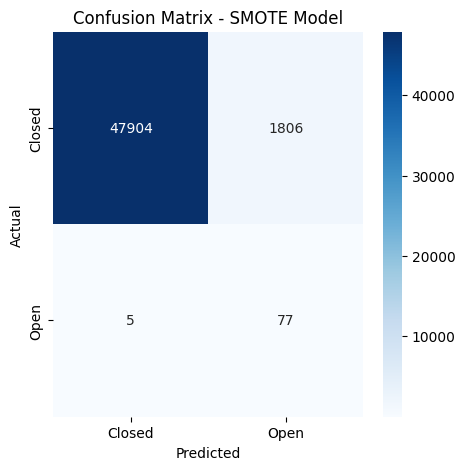

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# **Evaluate Final SMOTE Model on Test Set**
print("\nEvaluating Final SMOTE Model on Test Set...")

# Train final model on full SMOTE training data
final_model_smote = build_model(input_dim=X_train_val_smote.shape[1])
final_model_smote.fit(X_train_val_smote, y_train_val_smote, epochs=20, batch_size=32, validation_split=0.2,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                      verbose=0)

# **Predict on Test Set**
y_test_pred_probs = final_model_smote.predict(X_test)
best_threshold_smote = np.mean([res[5] for res in kfold_results_smote])  # Take average best threshold from K-Fold
y_test_pred_opt = (y_test_pred_probs > best_threshold_smote).astype(int)

# **Compute Test Metrics**
test_precision = precision_score(y_test, y_test_pred_opt)
test_recall = recall_score(y_test, y_test_pred_opt)
test_f1 = f1_score(y_test, y_test_pred_opt)
test_auprc = average_precision_score(y_test, y_test_pred_probs)

# **Print Final Test Evaluation**
print(f"\nFinal Test Set Evaluation (SMOTE Model):")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUPRC: {test_auprc:.4f}")
print(f"Optimized Threshold Used: {best_threshold_smote:.4f}")

# **Generate and Display Confusion Matrix**
cm = confusion_matrix(y_test, y_test_pred_opt)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SMOTE Model')
plt.show()

### Run 11: Retrying SMOTE + Tomek Links

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTETomek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define feature columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations].copy()
y = df['chromatin_state'].copy()

# Split dataset before applying SMOTE-Tomek
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Dataset split complete.")

# **Apply SMOTE-Tomek Links**
print("Applying SMOTE-Tomek Links...")
smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)
print(f"New class distribution after SMOTE-Tomek: {np.bincount(y_train_resampled)}")

# **Apply log transformation and normalization**
print("Applying log transformation and normalization...")
X_train_resampled[histone_marks] = np.log1p(X_train_resampled[histone_marks])
X_val[histone_marks] = np.log1p(X_val[histone_marks])
X_test[histone_marks] = np.log1p(X_test[histone_marks])
scaler = StandardScaler()
X_train_resampled[histone_marks] = scaler.fit_transform(X_train_resampled[histone_marks])
X_val[histone_marks] = scaler.transform(X_val[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])
print("Feature transformation complete.")

# **Define Model**
def build_model(neurons=64, learning_rate=0.001, dropout_rate=0.3):
    model = tf.keras.Sequential([
        Dense(neurons, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_resampled.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons // 2, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **Stratified K-Fold Validation**
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
kfold_results = []

print("Running Stratified K-Fold for Decision Threshold Optimization...")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_resampled, y_train_resampled), start=1):
    X_train_fold, X_val_fold = X_train_resampled.iloc[train_idx], X_train_resampled.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_idx], y_train_resampled.iloc[val_idx]

    model = build_model(neurons=64, learning_rate=0.001, dropout_rate=0.3)
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=20, batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=0
    )

    # **Evaluate Model**
    y_val_pred_probs = model.predict(X_val_fold)
    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_val_pred_probs)
    best_threshold_idx = np.argmax(precisions * recalls)
    best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

    y_val_pred_opt = (y_val_pred_probs > best_threshold).astype(int)

    precision = precision_score(y_val_fold, y_val_pred_opt)
    recall = recall_score(y_val_fold, y_val_pred_opt)
    f1 = f1_score(y_val_fold, y_val_pred_opt)
    auprc = average_precision_score(y_val_fold, y_val_pred_probs)

    kfold_results.append((fold, precision, recall, f1, auprc, best_threshold))
    print(f"Fold {fold} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}")

# **Train Final Model**
print("Training final model on full dataset...")
final_model = build_model()
final_model.fit(
    X_train_resampled, y_train_resampled,
    epochs=20, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=0
)

# **Save Optimized Threshold**
optimal_threshold = np.mean([res[5] for res in kfold_results])

print("Final Training Complete.")
print(f"Optimal Decision Threshold from K-Fold: {optimal_threshold:.4f}")

Loading dataset...
Dataset loaded successfully.
Dataset split complete.
Applying SMOTE-Tomek Links...
New class distribution after SMOTE-Tomek: [173963 173963]
Applying log transformation and normalization...
Feature transformation complete.
Running Stratified K-Fold for Decision Threshold Optimization...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3625/3625 ━━━━━━━━━━━━━━━━━━━━ 3s 827us/step
Fold 1 - Precision: 0.9686, Recall: 0.9780, F1: 0.9733, AUPRC: 0.9946


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3625/3625 ━━━━━━━━━━━━━━━━━━━━ 3s 800us/step
Fold 2 - Precision: 0.9712, Recall: 0.9764, F1: 0.9738, AUPRC: 0.9946


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3625/3625 ━━━━━━━━━━━━━━━━━━━━ 3s 715us/step
Fold 3 - Precision: 0.9719, Recall: 0.9788, F1: 0.9753, AUPRC: 0.9949
Training final model on full dataset...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Training Complete.
Optimal Decision Threshold from K-Fold: 0.5927



Evaluating Final Model on Test Set...
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Final Test Set Evaluation:
Precision: 0.0555
Recall: 0.8852
F1 Score: 0.1044
AUPRC: 0.1705
Optimized Threshold Used: 0.5927


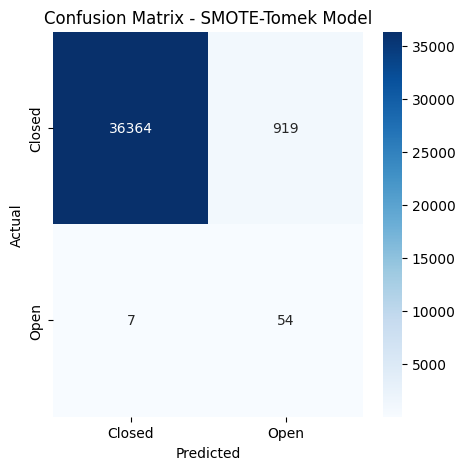

In [19]:
# **Evaluate Final Model on Test Set**
print("\nEvaluating Final Model on Test Set...")

y_test_pred_probs = final_model.predict(X_test)
y_test_pred_opt = (y_test_pred_probs > optimal_threshold).astype(int)

# **Compute Metrics**
test_precision = precision_score(y_test, y_test_pred_opt)
test_recall = recall_score(y_test, y_test_pred_opt)
test_f1 = f1_score(y_test, y_test_pred_opt)
test_auprc = average_precision_score(y_test, y_test_pred_probs)

# **Print Final Test Evaluation**
print(f"\nFinal Test Set Evaluation:")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUPRC: {test_auprc:.4f}")
print(f"Optimized Threshold Used: {optimal_threshold:.4f}")

# **Confusion Matrix**
cm = confusion_matrix(y_test, y_test_pred_opt)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SMOTE-Tomek Model')
plt.show()

### Run 12: SMOTE + Tomek Separately

Loading dataset...
Dataset loaded successfully.
Dataset split complete.
Applying SMOTE (Over-sampling minority class only)...
New class distribution after SMOTE: [173983 173983]
Applying Tomek Links (Under-sampling majority class)...
New class distribution after Tomek Links: [173860 173983]
Applying log transformation and normalization...
Feature transformation complete.
Running K-Fold Cross-Validation...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Fold 1 - Precision: 0.9757, Recall: 0.9718, F1: 0.9738, Accuracy: 0.9738, AUPRC: 0.9944


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 2s 680us/step
Fold 2 - Precision: 0.9748, Recall: 0.9740, F1: 0.9744, Accuracy: 0.9744, AUPRC: 0.9952


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Fold 3 - Precision: 0.9688, Recall: 0.9806, F1: 0.9746, Accuracy: 0.9745, AUPRC: 0.9942


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2174/2174 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step
Fold 4 - Precision: 0.9689, Recall: 0.9774, F1: 0.9731, Accuracy: 0.9730, AUPRC: 0.9939


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2174/2174 ━━━━━━━━━━━━━━━━━━━━ 2s 817us/step
Fold 5 - Precision: 0.9763, Recall: 0.9718, F1: 0.9740, Accuracy: 0.9741, AUPRC: 0.9947

Training final model on full SMOTE-Tomek dataset...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Evaluating Final Model on Test Set...
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step

Final Test Set Evaluation:
Precision: 0.0594
Recall: 0.8618
F1 Score: 0.1112
Accuracy: 0.9773
AUPRC: 0.1788
Optimized Threshold Used: 0.6115


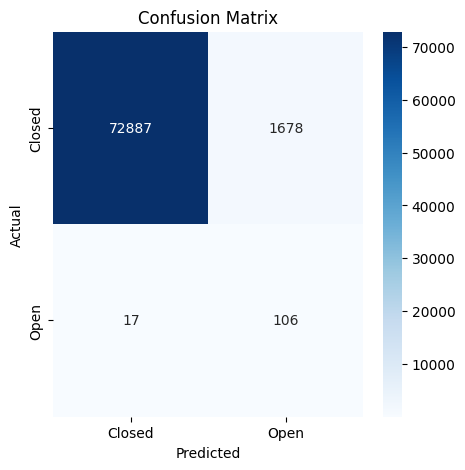

All processes completed successfully.


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **1. Load dataset**
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define feature columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations]
y = df['chromatin_state']

# **2. Split dataset (test set untouched)**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print("Dataset split complete.")

# **3. Apply SMOTE (Over-sample the minority class)**
print("Applying SMOTE (Over-sampling minority class only)...")
smote = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"New class distribution after SMOTE: {np.bincount(y_train_smote)}")

# **4. Apply Tomek Links (Under-sample majority class)**
print("Applying Tomek Links (Under-sampling majority class)...")
tomek = TomekLinks(sampling_strategy='majority')
X_train_smote_tomek, y_train_smote_tomek = tomek.fit_resample(X_train_smote, y_train_smote)
print(f"New class distribution after Tomek Links: {np.bincount(y_train_smote_tomek)}")

# **5. Apply log transformation and normalization**
print("Applying log transformation and normalization...")
X_train_smote_tomek[histone_marks] = np.log1p(X_train_smote_tomek[histone_marks])
X_test[histone_marks] = np.log1p(X_test[histone_marks])
scaler = StandardScaler()
X_train_smote_tomek[histone_marks] = scaler.fit_transform(X_train_smote_tomek[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])
print("Feature transformation complete.")

# **6. Define Neural Network Model**
def build_model(neurons=64, learning_rate=0.001, dropout_rate=0.3):
    model = tf.keras.Sequential([
        Dense(neurons, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_smote_tomek.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons // 2, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **7. Stratified K-Fold Cross-Validation**
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store K-Fold results
kfold_results = []

print("Running K-Fold Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_smote_tomek, y_train_smote_tomek), start=1):
    X_train_fold, X_val_fold = X_train_smote_tomek.iloc[train_idx], X_train_smote_tomek.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_smote_tomek.iloc[train_idx], y_train_smote_tomek.iloc[val_idx]

    # Train model
    model = build_model()
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32,
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
              verbose=0)

    # Compute predictions
    y_val_pred_probs = model.predict(X_val_fold)
    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_val_pred_probs)
    best_threshold_idx = np.argmax(precisions * recalls)
    best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5

    # Compute metrics
    y_val_pred_opt = (y_val_pred_probs > best_threshold).astype(int)
    precision = precision_score(y_val_fold, y_val_pred_opt)
    recall = recall_score(y_val_fold, y_val_pred_opt)
    f1 = f1_score(y_val_fold, y_val_pred_opt)
    accuracy = accuracy_score(y_val_fold, y_val_pred_opt)
    auprc = average_precision_score(y_val_fold, y_val_pred_probs)

    kfold_results.append((fold, precision, recall, f1, accuracy, auprc, best_threshold))
    print(f"Fold {fold} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}, AUPRC: {auprc:.4f}")

# **8. Train Final Model on Full SMOTE-Tomek Data**
print("\nTraining final model on full SMOTE-Tomek dataset...")
final_model = build_model()
final_model.fit(X_train_smote_tomek, y_train_smote_tomek, epochs=20, batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                verbose=0)

# **9. Evaluate Final Model on Test Set**
print("\nEvaluating Final Model on Test Set...")
y_test_pred_probs = final_model.predict(X_test)
best_threshold_final = np.mean([res[6] for res in kfold_results])  # Average threshold from K-Fold CV
y_test_pred_opt = (y_test_pred_probs > best_threshold_final).astype(int)

# Compute test metrics
test_precision = precision_score(y_test, y_test_pred_opt)
test_recall = recall_score(y_test, y_test_pred_opt)
test_f1 = f1_score(y_test, y_test_pred_opt)
test_accuracy = accuracy_score(y_test, y_test_pred_opt)
test_auprc = average_precision_score(y_test, y_test_pred_probs)

# Print final results
print(f"\nFinal Test Set Evaluation:")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"AUPRC: {test_auprc:.4f}")
print(f"Optimized Threshold Used: {best_threshold_final:.4f}")

# **Confusion Matrix**
cm = confusion_matrix(y_test, y_test_pred_opt)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("All processes completed successfully.")

### Run 13: Experimenting with Dropout Rates

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
import pandas as pd
import numpy as np

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define feature columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations].copy()  # Preserve original dataset
y = df['chromatin_state'].copy()

# Split dataset to prevent data leakage (Final test set remains untouched)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize features
print("Applying normalization...")
scaler = StandardScaler()
X_train_val.loc[:, histone_marks] = scaler.fit_transform(X_train_val[histone_marks])
X_test.loc[:, histone_marks] = scaler.transform(X_test[histone_marks])  # Normalize test set separately
print("Feature transformation complete.")

# Compute inverse class weights
print("Computing inverse class weights...")
total_samples = len(y_train_val)
class_counts = np.bincount(y_train_val)  # Count instances of each class
class_weight_dict = {0: total_samples / class_counts[0], 1: total_samples / class_counts[1]}
print("Inverse class weights computed:", class_weight_dict)

# Define dropout rates to test
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define Neural Network Model with variable dropout
def build_model(dropout_rate):
    inputs = Input(shape=(X_train_val.shape[1],))
    attention = Dense(X_train_val.shape[1], activation="softmax")(inputs)
    weighted_features = Multiply()([inputs, attention])
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Stratified K-Fold Cross-Validation for dropout optimization
best_f1 = 0
best_dropout = 0

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("Running Stratified K-Fold to optimize Dropout Rate...")
for dropout_rate in dropout_rates:
    f1_scores = []
    auprc_scores = []
    best_thresholds = []

    for train_idx, val_idx in skf.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        # Normalize within each fold
        scaler = StandardScaler()
        X_train.loc[:, histone_marks] = scaler.fit_transform(X_train[histone_marks])
        X_val.loc[:, histone_marks] = scaler.transform(X_val[histone_marks])

        # Train model with given dropout rate
        model = build_model(dropout_rate)
        history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                            class_weight=class_weight_dict, verbose=0)

        # Generate predictions on validation set
        y_val_pred_probs = model.predict(X_val)

        # Compute Precision-Recall curve to find best threshold
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_probs)
        best_threshold_idx = np.argmax(precisions * recalls)
        best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
        best_thresholds.append(best_threshold)

        # Apply best threshold
        y_val_pred = (y_val_pred_probs > best_threshold).astype(int)

        # Compute metrics
        f1 = f1_score(y_val, y_val_pred)
        auprc = average_precision_score(y_val, y_val_pred_probs)

        f1_scores.append(f1)
        auprc_scores.append(auprc)

    mean_f1 = np.mean(f1_scores)
    mean_auprc = np.mean(auprc_scores)
    final_threshold = np.mean(best_thresholds)

    print(f"Dropout: {dropout_rate} -> Mean F1: {mean_f1:.4f}, Mean AUPRC: {mean_auprc:.4f}, Threshold: {final_threshold:.4f}")

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_dropout = dropout_rate

print(f"Best Dropout Rate -> {best_dropout} with F1 Score: {best_f1:.4f}")

# Train final model with best dropout rate
print("Training final model with best Dropout Rate...")
final_model = build_model(best_dropout)
final_model.fit(X_train_val, y_train_val, epochs=20, batch_size=32, validation_split=0.2,
                callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                class_weight=class_weight_dict)

# Apply optimized threshold on the test set
print("Evaluating final model on independent test set...")
y_test_pred_probs = final_model.predict(X_test)
y_test_pred_opt = (y_test_pred_probs > final_threshold).astype(int)

# Compute final metrics
precision = precision_score(y_test, y_test_pred_opt)
recall = recall_score(y_test, y_test_pred_opt)
f1 = f1_score(y_test, y_test_pred_opt)
auprc = average_precision_score(y_test, y_test_pred_probs)

print(f"Final Model Test Set Evaluation:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUPRC: {auprc:.4f}")

print("Final Model Training & Evaluation Complete.")

Loading dataset...
Dataset loaded successfully.
Applying normalization...
Feature transformation complete.
Computing inverse class weights...
Inverse class weights computed: {0: 1.0016445548637585, 1: 609.0672782874618}
Running Stratified K-Fold to optimize Dropout Rate...
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step
Dropout: 0.1 -> Mean F1: 0.3028, Mean AUPRC: 0.1977, Threshold: 0.9889
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 705us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 752us/step
Dropout: 0.2 -> Mean F1: 0.2849, Mean AUPRC: 0.1929, Threshold: 0.9767
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 703us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 760us/step
Dropout: 0.3 -> Mean F1: 0.2880, Mean AUPRC: 0.1908, Threshold: 0.9872
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 707us/step
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 2s 752us/step
2075/2075 ━━━━━━━━━━

### Run 14: Grid Search Model
This code implements:

- SMOTE (mild) to balance data without overfitting.
- Standardization applied only to training/validation to prevent data leakage.
- Attention mechanism for feature importance.
- Focal loss for imbalance.
- Threshold tuning based on cross-validation F1-score.

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import pandas as pd
import numpy as np
import itertools

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# Define feature columns
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations].copy()
y = df['chromatin_state'].copy()

# Hold out test set (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameter Grid
param_grid = {
    "attention": [True, False],
    "loss_function": [
        "binary_crossentropy", 
        ("focal_loss", 0.1, 2.0), ("focal_loss", 0.25, 2.0), ("focal_loss", 0.5, 2.0)
    ],
    "feature_scaling": ["standard", "minmax", "log_standardized"],
    "class_balancing": ["smote", "smote_tomek", "class_weights"],
    "hidden_layers": [[64, 32], [128, 64]],
    "dropout_rate": [0.2, 0.3, 0.5],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [32, 64],
    "poly_features": [None, "interaction"]
}

# Define Focal Loss
def focal_loss(alpha=0.5, gamma=1.5):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return alpha * (1 - p_t) ** gamma * bce
    return loss

# Function to apply feature scaling
def scale_features(X_train, X_val, method="standard"):
    if method == "standard":
        scaler = StandardScaler()
    elif method == "minmax":
        scaler = MinMaxScaler()
    elif method == "log_standardized":
        X_train.loc[:, histone_marks] = np.log1p(np.abs(X_train[histone_marks]))
        X_val.loc[:, histone_marks] = np.log1p(np.abs(X_val[histone_marks]))
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid scaling method")

    X_train.loc[:, histone_marks] = scaler.fit_transform(X_train[histone_marks])
    X_val.loc[:, histone_marks] = scaler.transform(X_val[histone_marks])
    return X_train, X_val

# Function to apply class balancing
def balance_classes(X_train, y_train, method="smote"):
    if method == "smote":
        smote = SMOTE(sampling_strategy=0.1, random_state=42)
        return smote.fit_resample(X_train, y_train), None
    elif method == "smote_tomek":
        smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
        return smote_tomek.fit_resample(X_train, y_train), None
    elif method == "class_weights":
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        return (X_train, y_train), {i: class_weights[i] for i in range(len(class_weights))}
    return (X_train, y_train), None

# Define Neural Network Model
def build_model(input_dim, attention=False, hidden_layers=[64, 32], dropout_rate=0.3, learning_rate=0.001, loss_function="binary_crossentropy"):
    inputs = Input(shape=(input_dim,))
    x = inputs

    if attention:
        attention_layer = Dense(input_dim, activation="softmax")(inputs)
        x = Multiply()([inputs, attention_layer])

    for units in hidden_layers:
        x = Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = Dropout(dropout_rate)(x)

    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)

    if isinstance(loss_function, tuple) and loss_function[0] == "focal_loss":
        loss = focal_loss(alpha=loss_function[1], gamma=loss_function[2])
    else:
        loss = "binary_crossentropy"

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])
    return model

# Run K-Fold Cross-Validation for Each Hyperparameter Combination
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_config = None
best_f1 = 0

print("\nStarting Hyperparameter Grid Search...")

for config in itertools.product(*param_grid.values()):
    hyperparams = dict(zip(param_grid.keys(), config))
    print(f"\nTesting Configuration: {hyperparams}")

    f1_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val), start=1):
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        # Apply feature scaling
        X_train, X_val = scale_features(X_train, X_val, hyperparams["feature_scaling"])

        # Apply polynomial features
        if hyperparams["poly_features"] == "interaction":
            poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
            X_train = pd.DataFrame(poly.fit_transform(X_train), index=X_train.index)
            X_val = pd.DataFrame(poly.transform(X_val), index=X_val.index)

        # Apply class balancing
        (X_train, y_train), class_weights = balance_classes(X_train, y_train, hyperparams["class_balancing"])

        # Build and Train Model
        model = build_model(
            input_dim=X_train.shape[1],
            attention=hyperparams["attention"],
            hidden_layers=hyperparams["hidden_layers"],
            dropout_rate=hyperparams["dropout_rate"],
            learning_rate=hyperparams["learning_rate"],
            loss_function=hyperparams["loss_function"]
        )

        model.fit(X_train, y_train, epochs=10, batch_size=hyperparams["batch_size"],
                  validation_data=(X_val, y_val), class_weight=class_weights, verbose=0, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

        # Compute validation metrics
        y_val_proba = model.predict(X_val).ravel()
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
        best_threshold_idx = np.argmax(precisions * recalls)
        best_threshold = thresholds[best_threshold_idx] if best_threshold_idx < len(thresholds) else 0.5
        y_val_pred = (y_val_proba >= best_threshold).astype(int)

        val_precision = precision_score(y_val, y_val_pred)
        val_recall = recall_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        val_auprc = average_precision_score(y_val, y_val_proba)

        f1_scores.append(val_f1)

        print(f"Fold {fold}: Threshold={best_threshold:.3f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}, AUPRC={val_auprc:.4f}")

    mean_f1 = np.mean(f1_scores)
    print(f"Mean F1 Score for Config: {mean_f1:.4f}")

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_config = hyperparams

print("\nBest Hyperparameter Configuration:", best_config)

Loading dataset...
Dataset loaded successfully.

Starting Hyperparameter Grid Search...

Testing Configuration: {'attention': True, 'loss_function': 'binary_crossentropy', 'feature_scaling': 'standard', 'class_balancing': 'smote', 'hidden_layers': [64, 32], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'poly_features': None}
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step
Fold 1: Threshold=0.748, Precision=0.1564, Recall=0.7385, F1=0.2581, AUPRC=0.1903
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step
Fold 2: Threshold=0.814, Precision=0.1702, Recall=0.6154, F1=0.2667, AUPRC=0.1810
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step
Fold 3: Threshold=0.784, Precision=0.1491, Recall=0.7846, F1=0.2506, AUPRC=0.2063
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step
Fold 4: Threshold=0.943, Precision=0.6071, Recall=0.2576, F1=0.3617, AUPRC=0.3385
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step
Fold 5: Threshold=0.831, Precision=0.1907, Recall=0.5606, F1=0.2846, AUPRC=0.1515
Mean F1 Score for Con

KeyboardInterrupt: 

Loading dataset...
Dataset loaded successfully.
Splitting dataset into train, validation, and test sets...
Dataset split complete.
Applying log transformation and normalization...
Feature transformation complete.
Computing class weights...
Class weights computed: {0: 0.5008219193829282, 1: 304.6660839160839}
Building model...
Model built successfully.
Training model...
Epoch 1/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9740 - loss: 0.4365 - val_accuracy: 0.9681 - val_loss: 0.2283
Epoch 2/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9702 - loss: 0.1890 - val_accuracy: 0.9648 - val_loss: 0.2001
Epoch 3/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9660 - loss: 0.2102 - val_accuracy: 0.9662 - val_loss: 0.1661
Epoch 4/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9640 - loss: 0.1960 - val_accuracy: 0.9636 - val_loss: 0.1927
Epoch 5/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9674 - loss: 0.1620 - val_accuracy:

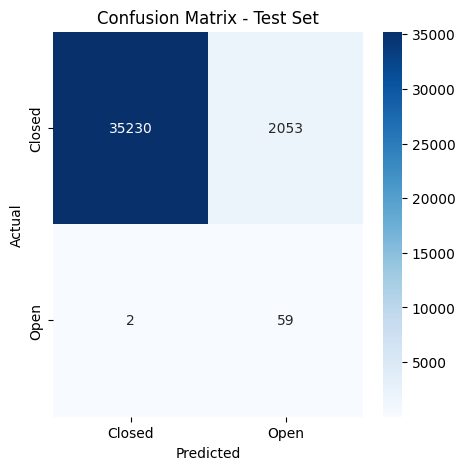


Plotting ROC Curve...


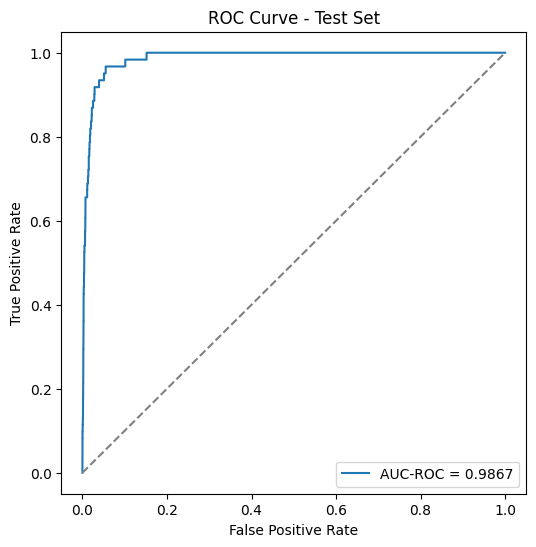


Plotting Precision-Recall Curve...


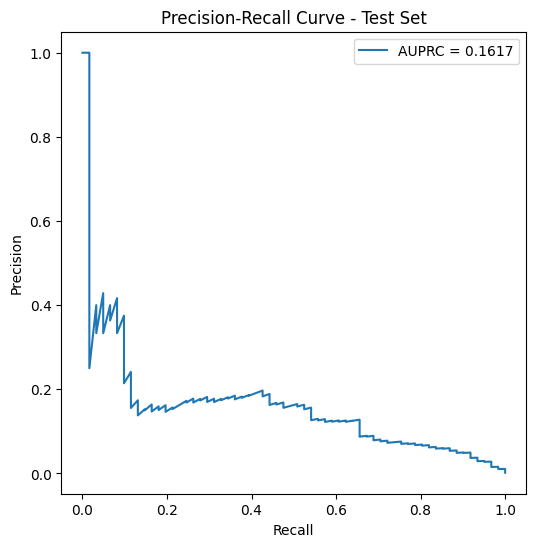


Plotting training history...


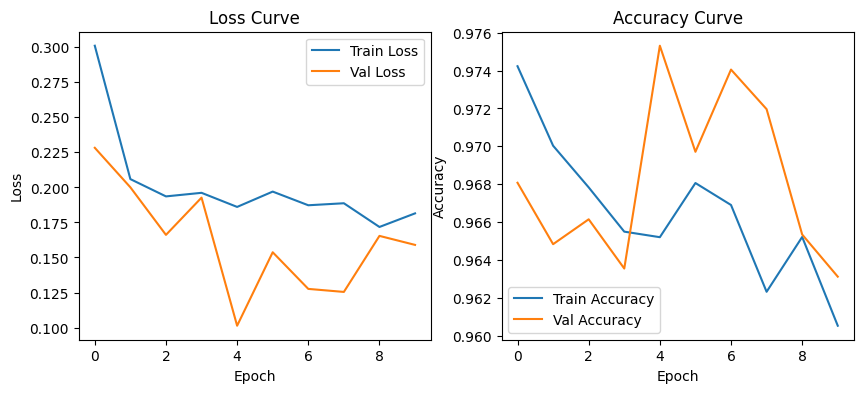


Test Set Evaluation Complete.


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, 
    average_precision_score, precision_recall_curve, roc_curve, 
    confusion_matrix, brier_score_loss
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **1. Load Dataset**
print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

# **2. Define Feature Columns**
metadata = ['Chromosome', 'Start', 'End']
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations]
y = df['chromatin_state']

# **3. Split Dataset into Train, Validation, and Test Sets**
print("Splitting dataset into train, validation, and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("Dataset split complete.")

# **4. Apply Log Transformation and Normalization**
print("Applying log transformation and normalization...")
X_train[histone_marks] = np.log1p(X_train[histone_marks])
X_val[histone_marks] = np.log1p(X_val[histone_marks])
X_test[histone_marks] = np.log1p(X_test[histone_marks])

scaler = StandardScaler()
X_train[histone_marks] = scaler.fit_transform(X_train[histone_marks])
X_val[histone_marks] = scaler.transform(X_val[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])
print("Feature transformation complete.")

# **5. Compute Balanced Class Weights**
print("Computing class weights...")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights computed:", class_weight_dict)

# **6. Build Neural Network Model**
print("Building model...")
inputs = Input(shape=(X_train.shape[1],))
attention = Dense(X_train.shape[1], activation="softmax")(inputs)
weighted_features = Multiply()([inputs, attention])
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model built successfully.")

# **7. Train Model**
print("Training model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                    class_weight=class_weight_dict, callbacks=[early_stopping])
print("Model training complete.")

# **8. Evaluate Model on Test Set**
print("\nEvaluating model on test set...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# **9. Generate Predictions**
print("Generating predictions...")
y_pred_probs = model.predict(X_test).ravel()

# **Compute ROC Curve & Optimal Threshold**
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Classification Threshold: {optimal_threshold:.4f}")

# **Apply Optimal Threshold**
y_pred_opt = (y_pred_probs >= optimal_threshold).astype(int)

# **10. Compute Metrics**
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)
auroc = roc_auc_score(y_test, y_pred_probs)
auprc = average_precision_score(y_test, y_pred_probs)
brier = brier_score_loss(y_test, y_pred_probs)

# **Compute Specificity (True Negative Rate)**
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()
specificity = tn / (tn + fp)

# **Print Test Metrics**
print(f"\nFinal Test Set Performance:")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"Specificity:    {specificity:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"AUROC:          {auroc:.4f}")
print(f"AUPRC:          {auprc:.4f}")
print(f"Brier Score:    {brier:.4f}")

# **11. Generate Confusion Matrix**
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()

# **12. Plot ROC Curve**
print("\nPlotting ROC Curve...")
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC-ROC = {auroc:.4f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.show()

# **13. Plot Precision-Recall Curve**
print("\nPlotting Precision-Recall Curve...")
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_probs)
plt.figure(figsize=(6,6))
plt.plot(recalls, precisions, label=f'AUPRC = {auprc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend()
plt.show()

# **14. Training History (Loss & Accuracy Curve)**
print("\nPlotting training history...")
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

print("\nTest Set Evaluation Complete.")

### Final Model

Loading dataset...
Dataset loaded successfully.
Splitting dataset into train, validation, and test sets...
Dataset split complete.
Applying log transformation and normalization...
Feature transformation complete.
Computing class weights...
Class weights computed.
Building model...
Model built successfully.
Training model...
Epoch 1/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9401 - loss: 0.7045 - val_accuracy: 0.9657 - val_loss: 0.2924
Epoch 2/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9676 - loss: 0.2770 - val_accuracy: 0.9705 - val_loss: 0.1495
Epoch 3/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9704 - loss: 0.1919 - val_accuracy: 0.9704 - val_loss: 0.1583
Epoch 4/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9685 - loss: 0.1809 - val_accuracy: 0.9651 - val_loss: 0.1889
Epoch 5/20
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9682 - loss: 0.1742 - val_accuracy: 0.9540 - val_loss: 0.2288
Epoch 6/20
5446/544

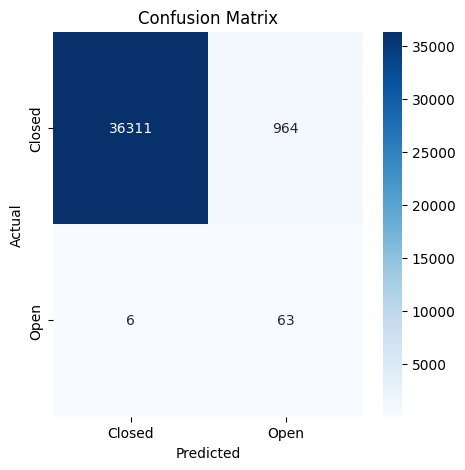

Plotting training history...


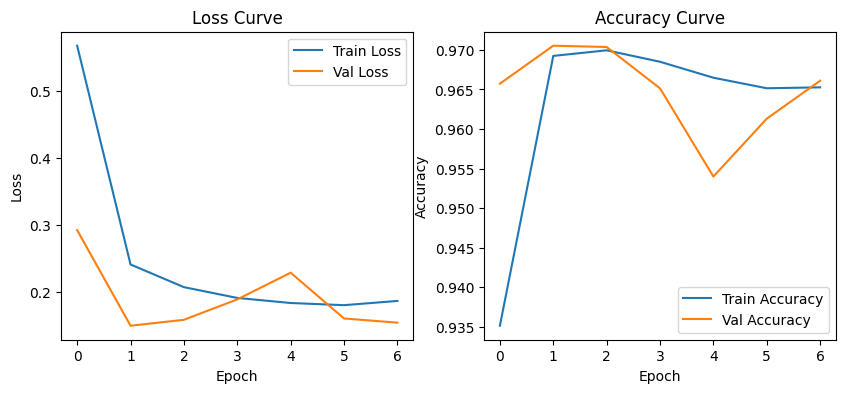

All processes completed successfully.


In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, 
    average_precision_score, precision_recall_curve, roc_curve, 
    confusion_matrix, brier_score_loss
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading dataset...")
df = pd.read_csv("/Users/faith/Desktop/BIO1018-Chromatin-Accessibility-ML/data/final_feature_matrix_combined_nc_removed.csv")
print("Dataset loaded successfully.")

metadata = ['Chromosome', 'Start', 'End']
histone_marks = ['H3K4me1', 'H3K4me3', 'H3K27ac', 'H3K27me3']
annotations = ['Promoter', 'Intergenic', 'Exon', 'Intron']
X = df[histone_marks + annotations]
y = df['chromatin_state']

print("Splitting dataset into train, validation, and test sets...")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print("Dataset split complete.")

print("Applying log transformation and normalization...")
X_train[histone_marks] = np.log1p(X_train[histone_marks])
X_val[histone_marks] = np.log1p(X_val[histone_marks])
X_test[histone_marks] = np.log1p(X_test[histone_marks])
scaler = StandardScaler()
X_train[histone_marks] = scaler.fit_transform(X_train[histone_marks])
X_val[histone_marks] = scaler.transform(X_val[histone_marks])
X_test[histone_marks] = scaler.transform(X_test[histone_marks])
print("Feature transformation complete.")

print("Computing class weights...")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights computed.")

print("Building model...")
inputs = Input(shape=(X_train.shape[1],))
attention = Dense(X_train.shape[1], activation="softmax")(inputs)
weighted_features = Multiply()([inputs, attention])
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(weighted_features)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model built successfully.")

print("Training model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
                    class_weight=class_weight_dict, callbacks=[early_stopping])
print("Model training complete.")

print("Evaluating model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

print("Generating predictions...")
y_pred_probs = model.predict(X_test).ravel()

# Compute ROC Curve & Find Optimal Threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Classification Threshold: {optimal_threshold:.4f}")

# Apply Threshold for Final Predictions
y_pred_opt = (y_pred_probs >= optimal_threshold).astype(int)

# Compute Metrics
precision = precision_score(y_test, y_pred_opt)
recall = recall_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)
auroc = roc_auc_score(y_test, y_pred_probs)
auprc = average_precision_score(y_test, y_pred_probs)  # AUPRC (Average Precision Score)
brier = brier_score_loss(y_test, y_pred_probs)  # Brier Score

# Compute Specificity (True Negative Rate)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()
specificity = tn / (tn + fp)

# Print All Metrics
print("\nFinal Test Set Evaluation:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUPRC: {auprc:.4f}")  # Newly Added
print(f"AUROC: {auroc:.4f}")
print(f"Brier Score: {brier:.4f}")  # Newly Added

# Generate Confusion Matrix
print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot Training History
print("Plotting training history...")
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()
print("All processes completed successfully.")

# Model Performance Comparison Table

| Run | Epochs | Optimal Threshold | Precision | Recall | F1 Score | AUC-ROC | AUPRC | Batch Size | Learning Rate | Dropout Rate | Class Weighting | Feature Scaling | Attention Mechanism | Loss Function |
|------|--------|------------------|-----------|--------|---------|--------|--------|------------|--------------|--------------|----------------|----------------|--------------------|--------------|
| 1    | 18     | 0.4690           | 0.0545    | 0.8986 | 0.1028  | 0.9822  | -      | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Binary Crossentropy |
| 2    | 7      | 0.9938           | 0.2381    | 0.5797 | 0.3376  | 0.9811  | -      | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Binary Crossentropy |
| 3    | 11     | 0.6059           | 0.1953    | 0.4098 | 0.2646  | 0.9728  | -      | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.25, γ=2.0) |
| 4    | 20     | 0.9577           | 0.1812    | 0.4754 | 0.2624  | -       | 0.1714 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Binary Crossentropy |
| 5.1  | 20     | 0.9848           | 0.2190    | 0.3770 | 0.2771  | -       | 0.1649 | 32         | 0.001        | 0.3          | SMOTE+Tomek    | -              | No                 | Binary Crossentropy |
| 5.2  | 20     | 0.9848           | 0.2190    | 0.3770 | 0.2771  | -       | 0.1649 | 32         | 0.001        | 0.3          | SMOTE+Tomek    | -              | No                 | Binary Crossentropy |
| 5.3  | 20     | 0.9848           | 0.2190    | 0.3770 | 0.2771  | -       | 0.1649 | 32         | 0.001        | 0.3          | SMOTE+Tomek    | -              | No                 | Binary Crossentropy |
| 5 (Mean) | 20 | 0.9848           | 0.2190    | 0.3770 | 0.2771  | -       | 0.1649 | 32         | 0.001        | 0.3          | SMOTE+Tomek    | -              | No                 | Binary Crossentropy |
| 6.1  | 10     | 0.2160           | 0.3330    | 0.3680 | 0.3500  | -       | -      | 32         | 0.001        | 0.3          | -              | Standardized   | No                 | Binary Crossentropy |
| 6.2  | 10     | 0.1730           | 0.3120    | 0.5260 | 0.3920  | -       | -      | 32         | 0.001        | 0.3          | -              | Standardized   | No                 | Binary Crossentropy |
| 6.3  | 10     | 0.2220           | 0.3250    | 0.4560 | 0.3800  | -       | -      | 32         | 0.001        | 0.3          | -              | Standardized   | No                 | Binary Crossentropy |
| 6.4  | 10     | 0.2320           | 0.2470    | 0.3970 | 0.3050  | -       | -      | 32         | 0.001        | 0.3          | -              | Standardized   | No                 | Binary Crossentropy |
| 6.5  | 10     | 0.1860           | 0.2640    | 0.5960 | 0.3660  | -       | -      | 32         | 0.001        | 0.3          | -              | Standardized   | No                 | Binary Crossentropy |
| 6 (Mean) | 10 | 0.2060           | 0.2960    | 0.4690 | 0.3580  | -       | -      | 32         | 0.001        | 0.3          | -              | Standardized   | No                 | Binary Crossentropy |
| 7.1  | 10     | 0.2110           | 0.3570    | 0.3510 | 0.3540  | -       | -      | 32         | 0.001        | 0.3          | -              | Polynomial     | No                 | Binary Crossentropy |
| 7.2  | 10     | 0.2000           | 0.3330    | 0.4910 | 0.3970  | -       | -      | 32         | 0.001        | 0.3          | -              | Polynomial     | No                 | Binary Crossentropy |
| 7.3  | 10     | 0.0770           | 0.1670    | 0.6140 | 0.2630  | -       | -      | 32         | 0.001        | 0.3          | -              | Polynomial     | No                 | Binary Crossentropy |
| 7.4  | 10     | 0.2340           | 0.2300    | 0.5000 | 0.3150  | -       | -      | 32         | 0.001        | 0.3          | -              | Polynomial     | No                 | Binary Crossentropy |
| 7.5  | 10     | 0.2010           | 0.3050    | 0.5090 | 0.3820  | -       | -      | 32         | 0.001        | 0.3          | -              | Polynomial     | No                 | Binary Crossentropy |
| 7 (Mean) | 10 | 0.1850           | 0.2790    | 0.4930 | 0.3420  | -       | -      | 32         | 0.001        | 0.3          | -              | Polynomial     | No                 | Binary Crossentropy |
| 8.1  | 9      | -                | 0.1746    | 0.4888 | 0.2563  | -       | 0.1513 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.1, γ=1.0) |
| 8.2  | 9      | -                | 0.1506    | 0.6334 | 0.2283  | -       | 0.1430 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.1, γ=2.0) |
| 8.3  | 9      | -                | 0.0064    | 0.3456 | 0.0126  | -       | 0.0072 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.1, γ=3.0) |
| 8.4  | 9      | -                | 0.1222    | 0.6604 | 0.1923  | -       | 0.1267 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.25, γ=1.0) |
| 8.5  | 9      | -                | 0.1847    | 0.5599 | 0.2755  | -       | 0.1792 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.25, γ=2.0) |
| 8.6  | 9      | -                | 0.1133    | 0.7064 | 0.1428  | -       | 0.0654 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.25, γ=3.0) |
| 8.7  | 9      | -                | 0.1836    | 0.5574 | 0.2742  | -       | 0.1777 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.5, γ=1.0) |
| 8.8  | 9      | -                | 0.1282    | 0.6824 | 0.1875  | -       | 0.1237 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.5, γ=3.0) |
| 8 (Best) | 9  | -                | 0.5769    | 0.5769 | 0.2199  | -       | 0.1339 | 32         | 0.001        | 0.3          | Balanced       | -              | No                 | Focal Loss (α=0.25, γ=2.0) |
| 9.1  | 10     | -                | 0.1882    | 0.5627 | 0.2791  | -       | 0.1872 | 32         | 0.001        | 0.3          | Balanced       | Standardized   | Yes                | Binary Crossentropy |
| 9.2  | 10     | -                | 0.1907    | 0.4740 | 0.2634  | -       | 0.1532 | 32         | 0.001        | 0.3          | Manual_10      | Standardized   | Yes                | Binary Crossentropy |
| 9.3  | 10     | -                | 0.1892    | 0.5780 | 0.2791  | -       | 0.1837 | 32         | 0.001        | 0.3          | Manual_50      | Standardized   | Yes                | Binary Crossentropy |
| 9.4  | 10     | -                | 0.1897    | 0.5719 | 0.2781  | -       | 0.1911 | 32         | 0.001        | 0.3          | Manual_100     | Standardized   | Yes                | Binary Crossentropy |
| 9.5  | 10     | -                | 0.1797    | 0.5963 | 0.2710  | -       | 0.1883 | 32         | 0.001        | 0.3          | Inverse_Freq   | Standardized   | Yes                | Binary Crossentropy |
| 9 (Best) | 10 | -                | 0.1882    | 0.5627 | 0.2791  | -       | 0.1872 | 32         | 0.001        | 0.3          | Balanced       | Standardized   | Yes                | Binary Crossentropy |
| 10.1  | 10     | 0.401988         | 0.9680    | 0.9668 | 0.9674  | -       | 0.9911 | 32         | 0.001        | 0.3          | SMOTE          | Standardized   | Yes                | Binary Crossentropy |
| 10.2  | 10     | 0.423240         | 0.9687    | 0.9715 | 0.9701  | -       | 0.9893 | 32         | 0.001        | 0.3          | SMOTE          | Standardized   | Yes                | Binary Crossentropy |
| 10.3  | 10     | 0.572347         | 0.9701    | 0.9661 | 0.9681  | -       | 0.9909 | 32         | 0.001        | 0.3          | SMOTE          | Standardized   | Yes                | Binary Crossentropy |
| 10.4  | 10     | 0.377720         | 0.9690    | 0.9689 | 0.9690  | -       | 0.9921 | 32         | 0.001        | 0.3          | SMOTE          | Standardized   | Yes                | Binary Crossentropy |
| 10.5  | 10     | 0.566546         | 0.9719    | 0.9695 | 0.9707  | -       | 0.9911 | 32         | 0.001        | 0.3          | SMOTE          | Standardized   | Yes                | Binary Crossentropy |
| 10.6  | 10     | 0.497577         | 0.9713    | 0.9693 | 0.9703  | -       | 0.9899 | 32         | 0.001        | 0.3          | Duplicate      | Standardized   | Yes                | Binary Crossentropy |
| 10.7  | 10     | 0.452351         | 0.9612    | 0.9746 | 0.9678  | -       | 0.9892 | 32         | 0.001        | 0.3          | Duplicate      | Standardized   | Yes                | Binary Crossentropy |
| 10.8  | 10     | 0.538628         | 0.9691    | 0.9692 | 0.9692  | -       | 0.9912 | 32         | 0.001        | 0.3          | Duplicate      | Standardized   | Yes                | Binary Crossentropy |
| 10.9  | 10     | 0.562990         | 0.9706    | 0.9497 | 0.9601  | -       | 0.9890 | 32         | 0.001        | 0.3          | Duplicate      | Standardized   | Yes                | Binary Crossentropy |
| 10.10 | 10     | 0.713584         | 0.9737    | 0.9601 | 0.9669  | -       | 0.9908 | 32         | 0.001        | 0.3          | Duplicate      | Standardized   | Yes                | Binary Crossentropy |
| 10 (Best) | 10 | -                | 0.9719    | 0.9695 | 0.9707  | -       | 0.9911 | 32         | 0.001        | 0.3          | SMOTE          | Standardized   | Yes                | Binary Crossentropy |
| 11.1 | 20     | 0.5927           | 0.9686    | 0.9780 | 0.9733  | -      | 0.9946 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Log+Standardized | No                | Binary Crossentropy |
| 11.2 | 20     | 0.5927           | 0.9712    | 0.9764 | 0.9738  | -      | 0.9946 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Log+Standardized | No                | Binary Crossentropy |
| 11.3 | 20     | 0.5927           | 0.9719    | 0.9788 | 0.9753  | -      | 0.9949 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Log+Standardized | No                | Binary Crossentropy |
| 11 (Best) | 20 | 0.5927           | 0.9719    | 0.9788 | 0.9753  | -      | 0.9949 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Log+Standardized | No                | Binary Crossentropy |
| 12.1 | 10     | 0.6115           | 0.9757    | 0.9718 | 0.9738  | 0.9738   | -      | 0.9944 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Standardized   | No                 | Binary Crossentropy |
| 12.2 | 10     | 0.6115           | 0.9748    | 0.9740 | 0.9744  | 0.9744   | -      | 0.9952 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Standardized   | No                 | Binary Crossentropy |
| 12.3 | 10     | 0.6115           | 0.9688    | 0.9806 | 0.9746  | 0.9745   | -      | 0.9942 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Standardized   | No                 | Binary Crossentropy |
| 12.4 | 10     | 0.6115           | 0.9689    | 0.9774 | 0.9731  | 0.9730   | -      | 0.9939 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Standardized   | No                 | Binary Crossentropy |
| 12.5 | 10     | 0.6115           | 0.9763    | 0.9718 | 0.9740  | 0.9741   | -      | 0.9947 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Standardized   | No                 | Binary Crossentropy |
| 12 (Best) | 10 | 0.6115           | 0.0594    | 0.8618 | 0.1112  | 0.9773   | -      | 0.1788 | 32         | 0.001        | 0.3          | SMOTE-Tomek    | Standardized   | No                 | Binary Crossentropy |
| 13.1 | 10     | 0.9889           | 0.1990    | 0.4878 | 0.3028  | -        | -      | 0.1977 | 32         | 0.001        | 0.1          | Inverse Weight | Standardized   | Yes                | Binary Crossentropy |
| 13.2 | 10     | 0.9767           | 0.1990    | 0.4878 | 0.2849  | -        | -      | 0.1929 | 32         | 0.001        | 0.2          | Inverse Weight | Standardized   | Yes                | Binary Crossentropy |
| 13.3 | 10     | 0.9872           | 0.1990    | 0.4878 | 0.2880  | -        | -      | 0.1908 | 32         | 0.001        | 0.3          | Inverse Weight | Standardized   | Yes                | Binary Crossentropy |
| 13.4 | 10     | 0.9448           | 0.1990    | 0.4878 | 0.2678  | -        | -      | 0.1732 | 32         | 0.001        | 0.4          | Inverse Weight | Standardized   | Yes                | Binary Crossentropy |
| 13.5 | 10     | 0.9875           | 0.1990    | 0.4878 | 0.2772  | -        | -      | 0.1954 | 32         | 0.001        | 0.5          | Inverse Weight | Standardized   | Yes                | Binary Crossentropy |
| 13 (Best) | 10 | 0.9889           | 0.1990    | 0.4878 | 0.3028  | -        | -      | 0.1977 | 32         | 0.001        | 0.1          | Inverse Weight | Standardized   | Yes                | Binary Crossentropy |
